In [1]:
import glob
import logging
from datetime import datetime

import numpy as np
import torch
from stable_baselines3.common import policies
from torch.utils.data import DataLoader

"""Run behavioral cloning on Waymo Open Dataset"""
import logging
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import sys
from pathlib import Path

os.chdir(path="/Research")
print(Path.cwd())
sys.path.append(os.path.abspath('/Research/gpudrive'))

from gpudrive.env.config import EnvConfig, SceneConfig
from gpudrive.env.env_torch import GPUDriveTorchEnv
from gpudrive.visualize.utils import img_from_fig
from gpudrive.env.dataset import SceneDataLoader
from dev.waymo_iterator import TrajectoryIterator
from torch.utils.data import DataLoader


/Research


In [2]:

DYNAMICS_MODEL = "delta_local" # "delta_local" / "state" / "classic"
DATA_PATH = "data/processed/examples" # Your data path
MAX_NUM_OBJECTS = 64
NUM_ENVS = 2
DEVICE = "cuda:0"

# Configs
env_config = EnvConfig(dynamics_model=DYNAMICS_MODEL)
# Make dataloader
scene_data_loader = SceneDataLoader(
    root="gpudrive/data/processed/examples", # Path to the dataset
    batch_size=NUM_ENVS, # Batch size, you want this to be equal to the number of worlds (envs) so that every world receives a different scene
    dataset_size=NUM_ENVS, # Total number of different scenes we want to use
    sample_with_replacement=False, 
    seed=42, 
    shuffle=True,   
)

print("Making the environment")

# Make environment
env = GPUDriveTorchEnv(
    config=env_config,
    data_loader=scene_data_loader,
    max_cont_agents=MAX_NUM_OBJECTS, # Maximum number of agents to control per scenario
    device=DEVICE, 
    action_type="continuous" # "continuous" or "discrete"
)

Making the environment
Compiling GPU engine code:
/Research/gpudrive/external/madrona/src/mw/device/memory.cpp
/Research/gpudrive/external/madrona/src/mw/device/state.cpp
/Research/gpudrive/external/madrona/src/mw/device/crash.cpp
/Research/gpudrive/external/madrona/src/mw/device/consts.cpp
/Research/gpudrive/external/madrona/src/mw/device/taskgraph.cpp
/Research/gpudrive/external/madrona/src/mw/device/taskgraph_utils.cpp
/Research/gpudrive/external/madrona/src/mw/device/sort_archetype.cpp
/Research/gpudrive/external/madrona/src/mw/device/host_print.cpp
/Research/gpudrive/external/madrona/src/mw/../common/hashmap.cpp
/Research/gpudrive/external/madrona/src/mw/../common/navmesh.cpp
/Research/gpudrive/external/madrona/src/mw/../core/base.cpp
/Research/gpudrive/external/madrona/src/mw/../physics/physics.cpp
/Research/gpudrive/external/madrona/src/mw/../physics/geo.cpp
/Research/gpudrive/external/madrona/src/mw/../physics/xpbd.cpp
/Research/gpudrive/external/madrona/src/mw/../physics/tgs.c

/Research/gpudrive/src/level_gen.cpp(283): warning #177-D: function "madrona_gpudrive::createFloorPlane" was declared but never referenced
  static void createFloorPlane(Engine &ctx)
              ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"





In [3]:
import torch
from torch import nn
from torch.distributions.categorical import Categorical

In [18]:
class SimpleNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNet, self).__init__()
        self.nn = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
        )
        self.mean_head = nn.Linear(hidden_size, output_size)       # Output: 3 means (mu)
        self.log_std = nn.Parameter(torch.ones(output_size) * 0.5, requires_grad=True)    # Output: 3 log-stds (log(sigma))

    def dist(self, obs):
        """Generate action distribution."""
        x_out = self.nn(obs.float())
        means = self.mean_head(x_out)        # shape: [batch_size, 3]
        stds = torch.exp(self.log_std)           # enforce positive std

        # Create independent normal distributions for each dimension
        dist = torch.distributions.Normal(loc=means, scale=stds)
        return dist

    def forward(self, obs, deterministic=False):
        """Generate an output from tensor input."""
        action_dist = self.dist(obs)
        if (deterministic): 
            return action_dist.mean, None
        else: 
            return action_dist.rsample(), None
    
    def log_prob(self, dist, expert_actions):
        # logging.info(f"Log prob sum: {dist.log_prob(expert_actions).sum(dim=-1)}"); 
        # logging.info(f"Log prob : {dist.log_prob(expert_actions).sum(dim=-1)}, STD: {dist.stddev}")
        return dist.log_prob(expert_actions).sum(dim=-1)
    
    def entropy(self, dist): 
        # logging.info(f"Entropy : {dist.entropy()}, {dist.stddev}")
        return dist.entropy().sum(dim=-1)

In [33]:
import importlib
# from imitation.algorithms import bc
import dev.bc as bc
from imitation.data.types import Transitions
import gymnasium as gym
from dev import policy
importlib.reload(policy)
from dev.policy import BCPolicy

In [34]:
def train_bc(
    env,
    scene_data_loader,
    bc_config,
    use_av_only, 
    train_epochs, 
    apply_obs_correction=False, 
    num_eval_episodes=100,
    log_interval=10_000,  
    *,
    max_samples_per_rollout=50, #50_000
):
    """Train a policy on Waymo Open Dataset using behavioral cloning.
        
    Args:
        env (GPUTorchEnv): Environment.
        num_train_files (int): Number of training files
        use_av_only (bool): Use only the AV vehicle to generate the dataset
        num_eval_episodes (int): Number of episodes to evaluate the policy
        max_samples_per_rollout: (int) Maximum number of samples per rollout.
            If the total number of samples is greater than this value, the
            training will be split into multiple rollouts. Default is 50,000.
    """
    rng = np.random.default_rng()
        
    # run = wandb.init( 
    #    project="eval_il_policy",
    #    sync_tensorboard=True,
    #    group=f"BC_S{num_train_files}",
    # )

    logging.info("(1/4) Create iterator...")
        
    traj_iterator = TrajectoryIterator(
        env=env,
        scene_data_loader=scene_data_loader
    )

    logging.info("(2/4) Generating dataset from traffic scenes...")

    #combine the spaces

    act_space_tuple = traj_iterator.action_space

    # obs_space_low = np.concatenate([s.low for s in obs_space_tuple.spaces])
    # obs_space_high = np.concatenate([s.high for s in obs_space_tuple.spaces])

    # concat_obs_space = gym.spaces.Box(low=obs_space_low, high=obs_space_high, dtype=np.float32)

    act_space_tuple = traj_iterator.action_space

    act_space_low = np.concatenate([s.low for s in act_space_tuple.spaces])
    act_space_high = np.concatenate([s.high for s in act_space_tuple.spaces])

    act_space = gym.spaces.Box(low=act_space_low, high=act_space_high, dtype=np.float32)
    obs_space = traj_iterator.observation_space
        
    # Make custom policy
    module = SimpleNet(
        input_size=obs_space.shape[0], 
        hidden_size=64, 
        output_size=len(traj_iterator.action_space)
    )

    print(f"Action space: {act_space}")

    policy = BCPolicy(obs_space, act_space, module)

    # policy = WrappedContinuousActorCriticPolicy(module, obs_space, traj_iterator.action_space)
        
    logging.info("(3/4) Training...")

    # Create for loop over rollouts:  
    # 1. Load rollout, create transitions, train policy
    # 2. If more rollouts to load, load and go to step 1
    # 3. If no more rollouts, evaluate policy
    # 4. Save policy
    num_samples = int(np.ceil(bc_config.total_samples / max_samples_per_rollout))
    for sample_idx in range(4):

        # Rollout to get obs-act-obs-done trajectories
        batch_size = 3000
        
        if num_samples > 1:
            logging.info(
                "Training on samples %d to %d",
                sample_idx * max_samples_per_rollout,
                (sample_idx + 1) * max_samples_per_rollout
            )
        
        rollouts = next(
            iter(
                DataLoader(
                    traj_iterator,
                    batch_size=batch_size,
                )
            )
        ) #returns a single batch of obs, action pairs

        print([i.shape for i in rollouts])

        # Convert to dataset of imitation "transitions"
        transitions = Transitions(
            obs=rollouts[0].cpu().numpy(),
            acts=rollouts[1].cpu().numpy(),
            infos=torch.zeros_like(rollouts[0]),  # Dummy
            next_obs=rollouts[2].cpu().numpy(),
            dones=rollouts[3].cpu().numpy().astype(bool),
        )  

        # Define trainer
        bc_trainer = bc.BC(
            policy=policy,
            observation_space=obs_space,
            action_space=act_space,
            demonstrations=transitions,
            rng=rng,
            device=torch.device(DEVICE),
        )

        # Train
        bc_trainer.train(
            n_epochs=train_epochs,
            log_interval=log_interval,
        )

    return policy

    # logging.info("(4/4) Evaluate policy...")
        
    # # Evaluate, get scores
    # df_bc = evaluate_policy(
    #    env_config=env_config,
    #    controlled_agents=1,
    #    data_path=env_config.data_path,
    #    mode="policy",
    #    policy=bc_trainer.policy,
    #    select_from_k_scenes=num_train_files,
    #    num_episodes=num_eval_episodes,
    #    use_av_only=True,
    # )
        
    # logging.info(f'--- Results: BC; AV ONLY ---')
    # print(df_bc[["goal_rate", "off_road", "veh_veh_collision"]].mean())
        
    # # Evaluate, get scores
    # df_bc_all = evaluate_policy(
    #    env_config=env_config,
    #    controlled_agents=1,
    #    data_path=env_config.data_path,
    #    mode="policy",
    #    policy=bc_trainer.policy,
    #    select_from_k_scenes=num_train_files,
    #    num_episodes=num_eval_episodes,
    #    use_av_only=False,
    # )
        
    # logging.info(f'--- Results: BC; RANDOM VEHICLE ---')
    # print(df_bc_all[["goal_rate", "off_road", "veh_veh_collision"]].mean())
        
    # # Save policy
    # if bc_config.save_model:
    #    if use_av_only:
    #       veh_type = "av_only"
    #    else:
    #       veh_type = "random"
    #    # Save model
    #    datetime_ = datetime_to_str(dt=datetime.now())
    #    save_path = f"{bc_config.save_model_path}" 
    #    name = f"{bc_config.model_name}_D{waymo_iterator.action_space.n}_S{num_train_files}_{datetime_}"
    #    bc_trainer.policy.save(
    #       path=f'{save_path}/{name}_{veh_type}.pt'
    #    )
    #    logging.info("(4/4) Saved policy!")
        
    #    # BEHAVIORAL CLONING
    #    human_policy = load_policy(
    #       data_path=save_path,
    #       file_name=f'{name}_{veh_type}', 
    #    )
        
    #    df_bc_loaded = evaluate_policy(
    #       env_config=env_config,
    #       controlled_agents=1,
    #       data_path=env_config.data_path,
    #       mode="policy",
    #       policy=human_policy,
    #       select_from_k_scenes=num_train_files,
    #       num_episodes=num_eval_episodes,
    #       use_av_only=True,
    #    )
        
    #    logging.info(f'--- Results: BEHAVIORAL CLONING LOADED ---')
    #    print(df_bc_loaded[["goal_rate", "off_road", "veh_veh_collision"]].mean())


In [35]:
from dev.config import getconfig

In [36]:
bc_config = getconfig("dev/configs/bc_config.yaml")
policy = train_bc(
    env=env,
    scene_data_loader=scene_data_loader,
    bc_config=bc_config,
    train_epochs=2,
    use_av_only=True,
    log_interval=200,
    num_eval_episodes=500,
)

INFO:root:(1/4) Create iterator...
INFO:root:(2/4) Generating dataset from traffic scenes...
INFO:root:(3/4) Training...
INFO:root:Training on samples 0 to 50
INFO:root:Generating expert actions and observations for 2 worlds 

INFO:root:Using continuous expert actions... 



Action space: Box([-2.   -2.   -3.14], [2.   2.   3.14], (3,), float32)


INFO:root:Generating expert actions and observations for 2 worlds 

INFO:root:Using continuous expert actions... 

INFO:root:Generating expert actions and observations for 2 worlds 

INFO:root:Using continuous expert actions... 

INFO:root:Generating expert actions and observations for 2 worlds 

INFO:root:Using continuous expert actions... 

INFO:root:Generating expert actions and observations for 2 worlds 

INFO:root:Using continuous expert actions... 



[torch.Size([3000, 2984]), torch.Size([3000, 3]), torch.Size([3000, 2984]), torch.Size([3000])]


0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | -0.00576 |
|    entropy        | 5.76     |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 33.3     |
|    loss           | 4.34     |
|    neglogp        | 4.34     |
|    prob_true_act  | 0.0131   |
|    samples_so_far | 32       |
--------------------------------


186batch [00:00, 273.54batch/s]
INFO:root:Training on samples 50 to 100
INFO:root:Generating expert actions and observations for 2 worlds 

INFO:root:Using continuous expert actions... 

INFO:root:Generating expert actions and observations for 2 worlds 

INFO:root:Using continuous expert actions... 

INFO:root:Generating expert actions and observations for 2 worlds 

INFO:root:Using continuous expert actions... 

INFO:root:Generating expert actions and observations for 2 worlds 

INFO:root:Using continuous expert actions... 

INFO:root:Generating expert actions and observations for 2 worlds 

INFO:root:Using continuous expert actions... 



[torch.Size([3000, 2984]), torch.Size([3000, 3]), torch.Size([3000, 2984]), torch.Size([3000])]


0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | -0.0052  |
|    entropy        | 5.2      |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 43.8     |
|    loss           | 3.69     |
|    neglogp        | 3.7      |
|    prob_true_act  | 0.0248   |
|    samples_so_far | 32       |
--------------------------------


186batch [00:00, 268.76batch/s]
INFO:root:Training on samples 100 to 150
INFO:root:Generating expert actions and observations for 2 worlds 

INFO:root:Using continuous expert actions... 

INFO:root:Generating expert actions and observations for 2 worlds 

INFO:root:Using continuous expert actions... 

INFO:root:Generating expert actions and observations for 2 worlds 

INFO:root:Using continuous expert actions... 

INFO:root:Generating expert actions and observations for 2 worlds 

INFO:root:Using continuous expert actions... 

INFO:root:Generating expert actions and observations for 2 worlds 

INFO:root:Using continuous expert actions... 



[torch.Size([3000, 2984]), torch.Size([3000, 3]), torch.Size([3000, 2984]), torch.Size([3000])]


0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | -0.00464 |
|    entropy        | 4.64     |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 52.3     |
|    loss           | 3.13     |
|    neglogp        | 3.14     |
|    prob_true_act  | 0.0433   |
|    samples_so_far | 32       |
--------------------------------


186batch [00:00, 269.32batch/s]
INFO:root:Training on samples 150 to 200
INFO:root:Generating expert actions and observations for 2 worlds 

INFO:root:Using continuous expert actions... 

INFO:root:Generating expert actions and observations for 2 worlds 

INFO:root:Using continuous expert actions... 

INFO:root:Generating expert actions and observations for 2 worlds 

INFO:root:Using continuous expert actions... 

INFO:root:Generating expert actions and observations for 2 worlds 

INFO:root:Using continuous expert actions... 

INFO:root:Generating expert actions and observations for 2 worlds 

INFO:root:Using continuous expert actions... 



[torch.Size([3000, 2984]), torch.Size([3000, 3]), torch.Size([3000, 2984]), torch.Size([3000])]


0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | -0.00408 |
|    entropy        | 4.08     |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 62.1     |
|    loss           | 2.58     |
|    neglogp        | 2.58     |
|    prob_true_act  | 0.0757   |
|    samples_so_far | 32       |
--------------------------------


186batch [00:00, 270.37batch/s]


In [37]:
def get_frames(policy):
    obs = env.reset()

    frames = {f"env_{i}": [] for i in range(NUM_ENVS)}

    for t in range(env_config.episode_len):

        obs = torch.reshape(obs, (-1, obs.shape[-1]))
        
        # Sample random actions
        action = policy(obs, True)[0]

        action = torch.reshape(action, (NUM_ENVS, MAX_NUM_OBJECTS, -1))

        # Step the environment
        env.step_dynamics(action)

        obs = env.get_obs()
        reward = env.get_rewards()
        done = env.get_dones()

        # Render the environment    
        if t % 5 == 0:
            imgs = env.vis.plot_simulator_state(
                env_indices=list(range(NUM_ENVS)),
                time_steps=[t]*NUM_ENVS,
                zoom_radius=70,
            )
        
            for i in range(NUM_ENVS):
                frames[f"env_{i}"].append(img_from_fig(imgs[i])) 
            
        if done.all():
            break
    return frames

env_0,env_1

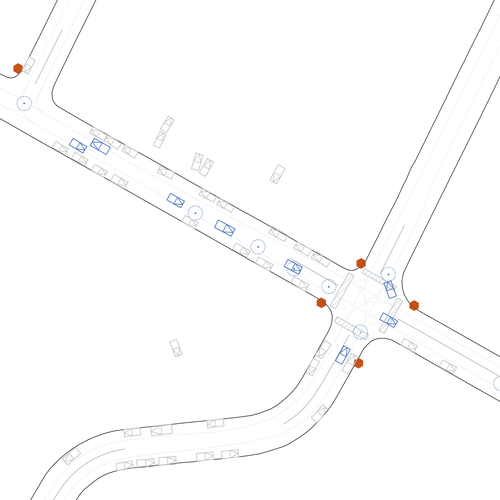
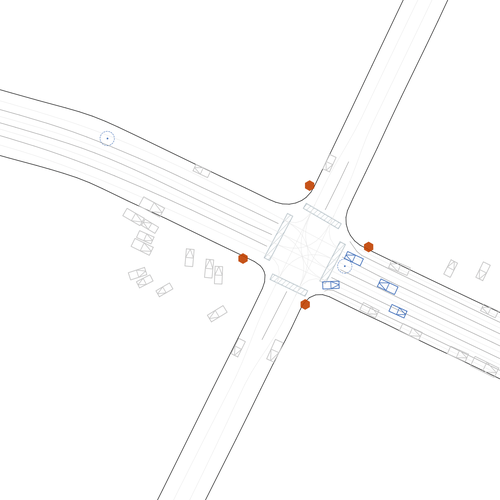

In [38]:
import mediapy
frames = get_frames(policy)
mediapy.show_videos(frames, fps=15, width=500, height=500, columns=2, codec='gif')

env_0,env_1

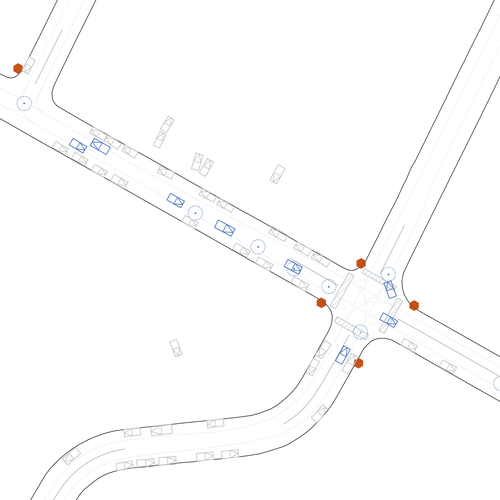
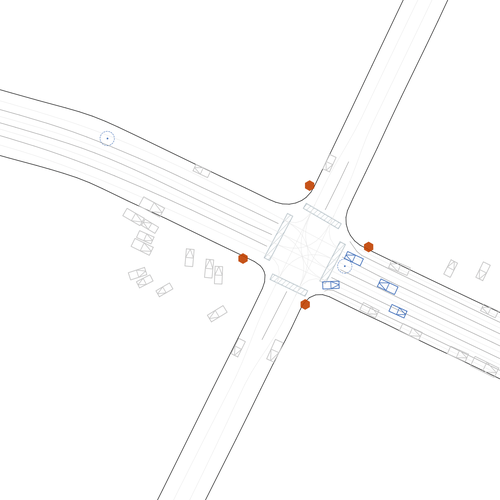

In [39]:
mediapy.show_videos(frames, fps=5, width=500, height=500, columns=2, codec='gif')

In [ ]:
env_